# Pitfalls of retrieval - when simple vector search fails!

In [1]:
# Create document chunks for embedding
from pypdf import PdfReader

# Read the PDF file
reader = PdfReader("microsoft_annual_report_2022.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]

# Filter the empty strings
pdf_texts = [text for text in pdf_texts if text]

from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)

character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

# Further split the chunks to prepare for embedding
token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

Ignoring wrong pointing object 6 0 (offset 0)
Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 20 0 (offset 0)
Ignoring wrong pointing object 22 0 (offset 0)
Ignoring wrong pointing object 43 0 (offset 0)
Ignoring wrong pointing object 49 0 (offset 0)
Ignoring wrong pointing object 51 0 (offset 0)
Ignoring wrong pointing object 53 0 (offset 0)
Ignoring wrong pointing object 55 0 (offset 0)
Ignoring wrong pointing object 57 0 (offset 0)
Ignoring wrong pointing object 72 0 (offset 0)
Ignoring wrong pointing object 162 0 (offset 0)
Ignoring wrong pointing object 229 0 (offset 0)
Ignoring wrong pointing object 231 0 (offset 0)
Ignoring wrong pointing object 252 0 (offset 0)
Ignoring wrong pointing object 257 0 (offset 0)
Ignoring wrong pointing object 294 0 (offset 0)
Ignoring wrong pointing object 299 0 (offset 0)
Ignoring wrong pointing object 319 0 (offset 0)
Ignoring wrong pointing object 331 0 (offset 0)
Ignoring wrong pointing object 336 0 (offset 0)
Ignor

In [2]:
# Setup chroma
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection("microsoft_annual_report_2022", embedding_function=embedding_function)

ids = [str(i) for i in range(len(token_split_texts))]

# Add documents to the vectorbase
chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

451

In [3]:
# Visualizing the embeddings
# umap is a dimensionality reduction technique which attempts to preserve the local structure of the data,
# meaaning that similar points in the original space will be close to each other in the reduced space.
import umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
# Project the embeddings to 2D space one by one for consistency in the projections
# This is because umap's results is sensitive to the inputs
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

In [5]:
# Run the projection function
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

  0%|          | 0/451 [00:00<?, ?it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 1/451 [00:00<04:55,  1.52it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 

(-7.571548962593079, 23.63064577579498, 1.1147564589977264, 11.103480345010757)

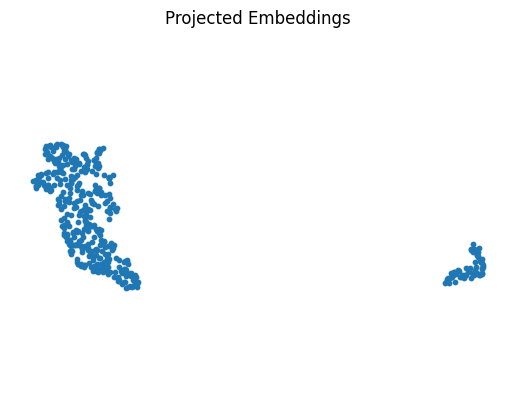

In [6]:
# Display the embeddings
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

## Pitfall 1: Distraction

In [7]:
# Query the collection just like before
query = "What is the total revenue?"

# Include the embeddings in the results this time for visualization
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

82 in addition, certain costs incurred at a corporate level that are identifiable and that benefit our segments are allocated to them. these allocated costs include legal, including settlements and fines, information technology, human resources, finance, excise taxes, field selling, shared facilities services, and customer service and support. each allocation is measured differently based on the specific facts and circumstances of the costs being allocated. segment revenue and operating income were as follows during the periods presented : ( in millions ) year ended june 30, 2022 2021 2020 revenue productivity and business processes $ 63, 364 $ 53, 915 $ 46, 398 intelligent cloud 75, 251 60, 080 48, 366 more personal computing 59, 655 54, 093 48, 251 total $ 198, 270 $ 168, 088 $ 143, 015 operating income

productivity and business processes $ 29, 687 $ 24, 351 $ 18, 724 intelligent cloud 32, 721 26, 126 18, 324 more personal computing 20, 975 19, 439 15, 911 total $ 83, 383 $ 69, 916 

In [8]:
# Project the query and retrieved embeddings to 2D space for visualization
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warni

(-7.571548962593079, 23.63064577579498, 1.1147564589977264, 11.103480345010757)

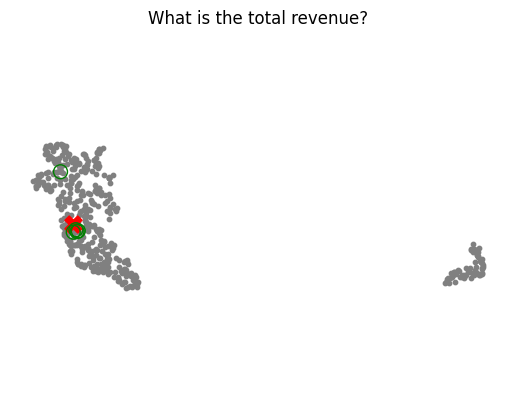

In [9]:
# Plot the projected query and retrieved documents in the embedding space
# Embeding will be marked by a red 'X' and retrieved documents will be marked by a green circles
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [10]:
# Experiment with another querry
query = "What is the strategy around artificial intelligence (AI) ?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print((document))
    print('')

. our ecosystem of customers and partners have learned that while hybrid work is complex, embracing flexibility, different work styles, and a culture of trust can help navigate the challenges the world faces today. organizations of all sizes have digitized business - critical functions, redefining what they can expect from their business applications. customers are looking to unlock value while simplifying security and management. from infrastructure and data, to business applications and collaboration, we provide unique, differentiated value to customers. we are building a distributed computing fabric – across cloud and the edge – to help every organization build, run, and manage mission - critical workloads anywhere. in the next phase of innovation, artificial intelligence ( “ ai ” ) capabilities are rapidly advancing, fueled by data and knowledge of the world

our commitment to responsibly develop and use technologies like ai is core to who we are. we put our commitment into practic

In [11]:
# Project the query and retrieved embeddings to 2D space for visualization
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warni

(-7.571548962593079, 23.63064577579498, 1.1147564589977264, 11.103480345010757)

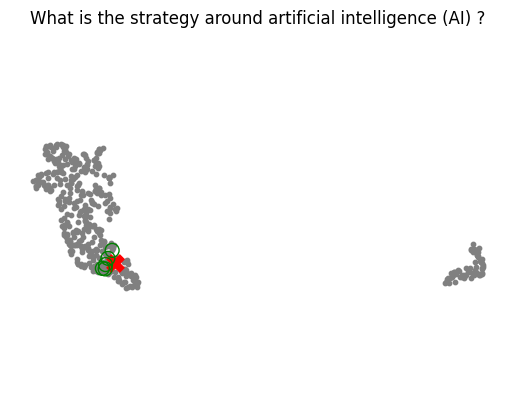

In [12]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [13]:
# Experiment with another query which should output some distracting results
# Distracting results are the ones that are not relevant to the query but are still retrived by the model
# The distracting results produce embeddings that are close to the query embedding in the embedding space
# This may be because of similar vocabulary as the one in the query despite their lack of relevance to the correct answer
query = "What has been the investment in research and development?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

research and development $ 24, 512 $ 20, 716 18 % as a percent of revenue 12 % 12 % 0ppt research and development expenses include payroll, employee benefits, stock - based compensation expense, and other headcount - related expenses associated with product development. research and development expenses also include third - party development and programming costs, localization costs incurred to translate software for international markets, and the amortization of purchased software code and services content. research and development expenses increased $ 3. 8 billion or 18 % driven by investments in cloud engineering, gaming, and linkedin. sales and marketing ( in millions, except percentages ) 2022 2021 percentage change

. investing in the future our success is based on our ability to create new and compelling products, services, and experiences for our users, to initiate and embrace disruptive technology trends, to enter new geographic and product markets, and to drive broad adoption

In [14]:
# Project the query and retrieved embeddings to 2D space for visualization
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warni

(-7.571548962593079, 23.63064577579498, 1.1147564589977264, 11.103480345010757)

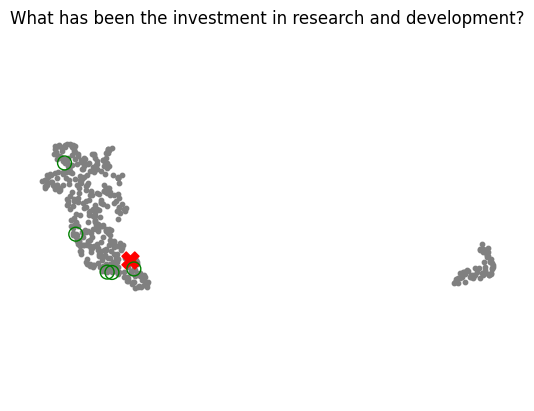

In [15]:
# Plot the projected query and retrieved documents in the embedding space
# We can visualize the distractions clearly by their distance to the query embedding in the 2D space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

## Pitfall 2: Relevancy

In [ ]:
# Experiment with a completely irrelevant query to the document
# The model doesn't have this knowledge and therefore behaves as if the query is relevant, returning virtually random results
query = "What has Michael Jordan done for us lately?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

. we disclose metrics to enable investors to evaluate progress against our ambitions, provide transparency into performance trends, and reflect the continued evolution of our products and services. our commercial and other business metrics are fundamentally connected based on how customers use our products and

43

. • operating expenses increased $ 1. 5 billion or 14 % driven by investments in gaming, search and news advertising, and windows marketing. operating expenses research and development ( in millions, except percentages ) 2022 2021 percentage change

• in - the - classroom learning, learning cohorts, our early - in - career aspire program, and manager excellence communities. • required learning for all employees and managers on topics such as compliance, regulation, company culture, leadership, and management. this includes the annual standards of business conduct training. • on - the - job “ stretch ” and advancement opportunities. • managers holding conversations about empl

In [17]:
# Project the query and retrieved embeddings to 2D space for visualization
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warni

(-7.571548962593079, 23.63064577579498, 1.1147564589977264, 11.103480345010757)

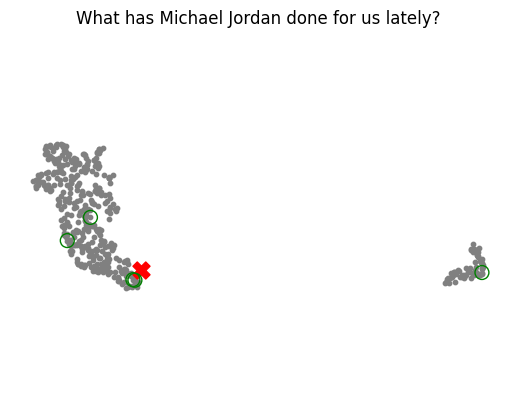

In [18]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')